In [ ]:
# Standard libraries
import os
import random
from contextlib import redirect_stdout

# Data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PIL and image handling
from PIL import Image, UnidentifiedImageError

# OpenCV
import cv2

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

# Torchvision
import torchvision
from torchvision import transforms, models
from torchvision.models import (
    efficientnet_b0, EfficientNet_B0_Weights,
    efficientnet_b3, EfficientNet_B3_Weights
)
import torchvision.transforms.functional as TF

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)

# Progress bar
from tqdm.notebook import tqdm


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Defining paths 
base_path = "../dataset_coin_classifications"
train_csv_path = "../dataset_coin_classification/train.csv"
test_csv_path = "../dataset_coin_classification/test.csv"
sample_submission_path = "../dataset_coin_classification/sample_submission.csv"

# Define image directories
train_img_dir = "../dataset_coin_classification/train"
test_img_dir = "../dataset_coin_classification/test"

# Load datasets
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
sample_submission = pd.read_csv(sample_submission_path)

# Print information about the datasets
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Using device: cuda
Training set size: 10368
Test set size: 1282


In [ ]:
def filter_valid_images(image_data, image_directory):
    valid_images = []
    
    for _, row in tqdm(image_data.iterrows(), desc="Validating images", total=len(image_data)):
        image_filename = f"{row['Id']}.jpg"
        image_path = os.path.join(image_directory, image_filename)
        
        try:
            with Image.open(image_path) as img:
                img.verify()  # Verifies if image is valid
            valid_images.append(row)
        except (UnidentifiedImageError, OSError, FileNotFoundError):
            continue  # Skip invalid images
    
    return pd.DataFrame(valid_images).reset_index(drop=True)

train_df = pd.read_csv(train_csv_path)
train_df = filter_valid_images(train_df, train_img_dir)

print(f"Cleaned dataset size: {len(train_df)}")


Validating images: 100%|██████████| 10368/10368 [00:20<00:00, 507.30it/s]


Cleaned dataset size: 9790


In [ ]:
# Encode the 'Class' column into numerical labels
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['Class'])



['label_encoder.pkl']

In [ ]:
# Split the dataset into training and validation sets
train_df, val_df = train_test_split(
    train_df,                
    test_size=0.2,           
    random_state=42,         
    stratify=train_df['Class']  
)

# Check the split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")


Training set size: 7832
Validation set size: 1958


In [ ]:
# CoinDataset class to handle image loading and transformations
class CoinDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, raise_error=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.raise_error = raise_error

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.at[idx, 'Id']
        img_name = f"{img_id}.jpg"
        img_path = os.path.join(self.img_dir, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            if self.raise_error:
                raise FileNotFoundError(f"[ERROR] Image not found: {img_path}")
            else:
                print(f"[WARNING] Image not found: {img_path} — using black image.")
                image = Image.new("RGB", (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        label = self.df.at[idx, 'label']
        return image, label


### Basic Exploratory Data Analysis


In [ ]:
num_classes = train_df['Class'].unique()
print(f'Number of classes: {num_classes}')

class_counts = train_df['Class'].value_counts()
class_counts.head(10)

### Distribution of the Top 10 Classes
Let's visualize the 10 most common classes

In [8]:
top_10 = class_counts.head(10)
plt.figure(figsize=(8, 4))
top_10.plot(kind='bar')
plt.title('Top 10 Classes by Image Count')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.show()

NameError: name 'class_counts' is not defined

### Applying Basic Data Augmentation before training on `ResNet18`

In [ ]:

# Basic image transforms
def get_transforms(img_size=224):
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

    return train_transform, val_transform

# Create transforms
train_transform, val_transform = get_transforms()

# Create datasets
train_dataset = CoinDataset(train_df, train_img_dir, transform=train_transform)
val_dataset = CoinDataset(val_df, train_img_dir, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, num_workers = 2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers = 2, shuffle=False)

In [ ]:


def imshow(img, title):
    img = img.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')



def train_model(model, train_loader, val_loader, 
                criterion, optimizer, scheduler = None, n_epochs=10, 
                device='cuda', model_name = "ResNet_18",
                use_early_stopping=False, patience = 3,
                use_scheduler=False, scheduler_step='epoch',
                num_classes = 315, sample_classes_count = 10):
    best_model_wts = None
    best_acc = 0.0
    early_stop_counter = 0
    print("Starting training...")



    # Arrays of training losses and accuracies for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []


    sampled_classes = sorted(random.sample(range(num_classes), sample_classes_count))


    for epoch in range(n_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels)
            total_train += labels.size(0)

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train.double() / total_train

        # Validation loop
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += torch.sum(preds == labels)
                total_val += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val.double() / total_val

        
        if use_scheduler and scheduler:
            if scheduler_step == 'epoch':
                scheduler.step()
            elif scheduler_step == 'val_loss':
                scheduler.step(val_loss)


        # Save the best model
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_model_wts = model.state_dict()
            early_stop_counter = 0
        else:
            early_stop_counter += 1


        # Plot training and validation losses and accuracies
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy.item())
        val_accuracies.append(val_accuracy.item())

        # Print results for the current epoch
        print(f"Epoch {epoch+1}/{n_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
        log_path = f"../logs/log_{model_name}.txt"

    with open(log_path, "w") as f:
        with redirect_stdout(f):

            # ===== Your entire train_model code here unchanged =====
            # Example:
            print(f"Starting training for {model_name}")

            for epoch in range(n_epochs):
                # your epoch code here...
                print(f"Epoch {epoch+1}/{n_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

            print(f"Training completed. Best Val Acc: {best_acc}")

        
        
        # Printing the f1-score, recall and precision after every epoch

        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")

        # if use_early_stopping and early_stop_counter >= patience:
        #     break

        # Plot confusion matrix after every epoch (sampled classes)
        cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
        cm_sample = cm[np.ix_(sampled_classes, sampled_classes)]

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_sample, annot=True, fmt='d', cmap='Blues',
                    xticklabels=sampled_classes, yticklabels=sampled_classes)
        plt.title(f'Confusion Matrix (Sample Classes) - Epoch {epoch+1}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.savefig(f"../plots/confusion_matrix_{epoch+1}_{model_name}.png")
        plt.close()

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # Plot loss and accuracy graphs
    epochs_range = range(n_epochs)
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"../plots/loss_accuracy_{model_name}.png")
    plt.show()

    # Save the best model
    torch.save(best_model_wts, f'../models/{model_name}.pth')

    # Plotting the misclassified images after training
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            mis = preds != labels
            for img, pred, label, is_mis in zip(images, preds, labels, mis):
                if is_mis:
                    misclassified.append((img.cpu(), pred.item(), label.item()))
                if len(misclassified) >= 8:
                    break
            if len(misclassified) >= 8:
                break

    # Show misclassified images
    if misclassified:
        plt.figure(figsize=(12, 6))
        for i, (img, pred, true) in enumerate(misclassified):
            # Convert tensor to numpy if necessary
            if hasattr(img, 'cpu'):
                img_np = img.cpu().numpy()
            else:
                img_np = img

            # If it's normalized (e.g. 0-1), scale back to 0-255
            if img_np.max() <= 1.0:
                img_np = (img_np * 255).astype(np.uint8)
            else:
                img_np = img_np.astype(np.uint8)

            # Convert to grayscale for analysis if it's RGB or has channels
            if img_np.ndim == 3 and img_np.shape[0] in [1, 3]:  # Channels first (C, H, W)
                img_np = img_np.transpose(1, 2, 0)  # To (H, W, C)
            if img_np.ndim == 3:
                gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
            else:
                gray = img_np

            # Calculate mean and std dev
            mean_intensity = np.mean(gray)
            std_dev_intensity = np.std(gray)

            # Print the stats
            print(f"Image {i+1} | Pred: {pred} | True: {true} | Mean: {mean_intensity:.2f} | Std Dev: {std_dev_intensity:.2f}")

            # Show image
            plt.subplot(2, 4, i+1)
            plt.imshow(gray, cmap='gray')
            plt.title(f"Pred: {pred}\nTrue: {true}")
            plt.axis('off')

        plt.tight_layout()
        plt.suptitle("Misclassified Images", fontsize=16, y=1.05)
        plt.show()


    return model


Training Frozen `ResNet18` with parameters
- Number Of Epochs: 10 
- Loss Function: Cross Entropy Loss
- Optimizer: Adam with learning rate $10^{-4}$


In [ ]:

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze 'layer4' block and 'fc'
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True


# Defining final layer
model.fc = nn.Linear(model.fc.in_features, 315)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-4
)


In [ ]:
# Train the model using the train_model function
n_epochs = 10


model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    device=device,
    model_name="ResNet_18",
)


### Observation
 Freezing the **earlier layers** still leads to decent accuracies, like around 82 % with our `ResNet18` model since the earlier layers are good at detecting low-level features such as edges and shapes. The final layer `model.fc` captures complex patters, hence this `ResNet18` CNN model can be generalized to many tasks.

 ### Advantages
 **Less Parameter Update**: Since you're freezing most of the model's parameters, the number of parameters being updated during training is significantly reduced. This leads to faster computation in each iteration because fewer gradients need to be calculated and applied.

**Lower Memory Usage**: Fewer parameters to update means less memory usage during training, which can improve training speed, especially if you're working with limited GPU memory(colab)


### Fine-Tuning with `ResNet18`
We now **unfreeze** all the layers of the model and restart training with same hyperparameters


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained resnet18 with all layers unfrozen
model = models.resnet18(pretrained=True)

# Replace the final classification layer for 315 classes
model.fc = nn.Linear(model.fc.in_features, 315)

# Move to device
model = model.to(device)


In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Number of epochs
n_epochs = 10


In [ ]:
# Train the fully unfrozen model
model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    device=device,
    model_name = "ResNet18_fine_tune"
)




### Model Performance Comparison

We evaluated the performance of two configurations of the ResNet18 model: one with the convolutional base **frozen**, and the other with it **unfrozen** (i.e., full fine-tuning). The results are summarized below:

* **Frozen CNN**

  * **Training Accuracy**: 93.36%
  * **Validation Accuracy**: 75.86%

* **Unfrozen CNN**

  * **Training Accuracy**: 96.28%
  * **Validation Accuracy**: 80.33%

Interestingly, the **training time for both configurations was nearly identical**, with the frozen model completing in **4 minutes 15 seconds**, and the unfrozen model in **4 minutes 22 seconds**. This minimal time difference is somewhat unexpected, as training a frozen network involves updating significantly fewer parameters compared to a fully trainable one.

However, the accuracy difference aligns with expectations. The unfrozen model benefits from full gradient flow through all layers, allowing it to adapt more specifically to the dataset. This flexibility leads to improved performance on both the training and validation sets.




## Hyperparameter Tuning
We are running experiments to evaluate how key hyperparameters affect model performance. Specifically, we vary:

Learning Rate: 1e-3, 1e-4

Batch Size: 64, 128

Fully Connected Hidden Units: 256, 1024

Dropout Rate: 0.2, 0.5

Each combination is trained for 10 epochs using the same training and validation sets. The goal is to identify a balanced model in terms of training speed, accuracy, and generalization.



In [ ]:


# Define your experiment configurations
experiments = [
    {"lr": 1e-4, "batch_size": 64, "hidden_units": 256, "dropout": 0.2},
    {"lr": 1e-4, "batch_size": 64, "hidden_units": 1024, "dropout": 0.5},
    {"lr": 1e-3, "batch_size": 128, "hidden_units": 256, "dropout": 0.5},
]

for i, config in enumerate(experiments):
    log_path = f"../logs/log_resnet18_exp{i+1}.txt"
    with open(log_path, "w") as f:
        with redirect_stdout(f):
            print(f"\n=== Experiment {i+1} ===")
            print(f"LR: {config['lr']}, Batch Size: {config['batch_size']}, Hidden Units: {config['hidden_units']}, Dropout: {config['dropout']}")

            # Reload dataloaders
            train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], num_workers=2, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], num_workers=2, shuffle=False)

            # Load ResNet18
            model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            for param in model.parameters():
                param.requires_grad = True

            # Custom FC head
            model.fc = nn.Sequential(
                nn.Linear(model.fc.in_features, config['hidden_units']),
                nn.ReLU(),
                nn.Dropout(config['dropout']),
                nn.Linear(config['hidden_units'], 315)
            )

            model = model.to(device)

            # Loss and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=config['lr'])    

            # Train
            train_model(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                n_epochs=10,
                model_name=f"resnet18_exp{i+1}"
            )



## Experiment Summary

### Experiment Results

* **Learning Rate**: 1e-4
* **Batch Size**: 64
* **Hidden Units**: 1024
* **Dropout**: 0.5

### Performance:

* **Best Performing Experiment**:

  * **Train Accuracy**: 86.66%
  * **Val Accuracy**: 83.25%
  * **Precision**: 0.8355
  * **Recall**: 0.8169
  * **F1-score**: 0.8112
* This configuration shows the best balance between training and validation accuracy, with the lowest gap between the two, suggesting better generalization.

### Observations:

* The model with a **learning rate of 1e-4**, **dropout of 0.5**, and **1024 hidden units** worked best in preventing overfitting while maintaining good performance on the validation set.
* The model with **learning rate 1e-3** and **batch size 128** showed signs of **divergence** (very high loss and low accuracy), which suggests the learning rate might have been too high for the model.



The high difference between training accuracy and validation accuracy in most of the models indicates **overfitting**. </br>
Let's try
- Early Stopping
- Data augmentation
- Label Smoothing
- Scheduler
- L2 regularization with momentum

In [ ]:
class RandomOcclusion:
    def __init__(self, occlusion_size=16, max_occlusions=1, occlusion_color=(128, 128, 128)):
        self.occlusion_size = occlusion_size
        self.max_occlusions = max_occlusions
        self.occlusion_color = occlusion_color

    def __call__(self, img):
        w, h = img.size
        num_occlusions = random.randint(1, self.max_occlusions)
        img = img.copy()
        
        for _ in range(num_occlusions):
            top = random.randint(0, h - self.occlusion_size)
            left = random.randint(0, w - self.occlusion_size)
            occlusion = Image.new('RGB', (self.occlusion_size, self.occlusion_size), self.occlusion_color)
            img.paste(occlusion, (left, top))
        
        return img




# Adjusted transformations with more cautious parameters
def get_transforms(img_size=224, use_occlusion=True):
    train_transform_list = [
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(15),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]
    if use_occlusion:
        train_transform_list.insert(0, RandomOcclusion())  # Add occlusion only for training

    train_transform = transforms.Compose(train_transform_list)

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    return train_transform, val_transform



train_transform, val_transform = get_transforms()


# Create datasets
train_dataset = CoinDataset(train_df, train_img_dir, transform=train_transform)
val_dataset = CoinDataset(val_df, train_img_dir, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


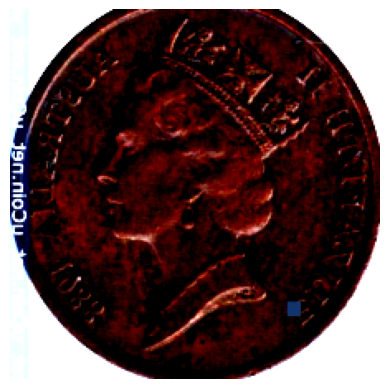

In [ ]:

# Load an image
img_path = "../dataset_coin_classification/train/8.jpg"
img = Image.open(img_path)

# Define transformation (with occlusion)
train_transform, _ = get_transforms()

# Apply the transformation
img_transformed = train_transform(img)

# Convert the tensor back to an image for visualization
img_transformed = img_transformed.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

# Display the image
plt.imshow(img_transformed)
plt.axis('off')  # Hide axes
plt.show()


In [26]:
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")


Number of batches in train_loader: 245
Number of batches in val_loader: 62


[INFO] Starting training...
Epoch 1/15 - Train Loss: 5.2126, Train Acc: 0.0636, Val Loss: 4.4090, Val Acc: 0.1032
Epoch 2/15 - Train Loss: 4.1026, Train Acc: 0.1470, Val Loss: 3.2584, Val Acc: 0.2615
Epoch 3/15 - Train Loss: 3.2340, Train Acc: 0.2490, Val Loss: 2.4259, Val Acc: 0.3912
Epoch 4/15 - Train Loss: 2.5184, Train Acc: 0.3648, Val Loss: 1.7285, Val Acc: 0.5495
Epoch 5/15 - Train Loss: 1.9763, Train Acc: 0.4801, Val Loss: 1.4727, Val Acc: 0.6261
Epoch 6/15 - Train Loss: 1.6094, Train Acc: 0.5587, Val Loss: 1.2037, Val Acc: 0.6777
Epoch 7/15 - Train Loss: 1.3270, Train Acc: 0.6207, Val Loss: 1.0708, Val Acc: 0.7022
Epoch 8/15 - Train Loss: 1.1311, Train Acc: 0.6733, Val Loss: 0.9682, Val Acc: 0.7441
Epoch 9/15 - Train Loss: 0.9467, Train Acc: 0.7195, Val Loss: 0.8733, Val Acc: 0.7640
Epoch 10/15 - Train Loss: 0.8290, Train Acc: 0.7501, Val Loss: 0.8709, Val Acc: 0.7850
Epoch 11/15 - Train Loss: 0.7157, Train Acc: 0.7808, Val Loss: 0.7513, Val Acc: 0.8008
Epoch 12/15 - Train Loss

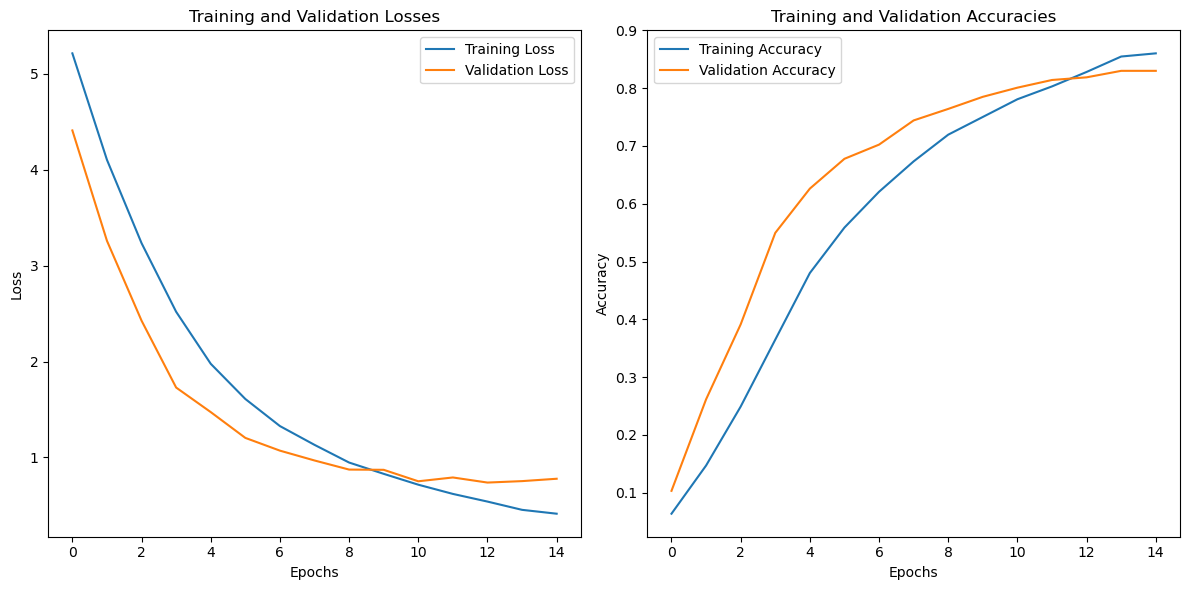

Image 1 | Pred: 232 | True: 227 | Mean: 6.05 | Std Dev: 35.86
Image 2 | Pred: 198 | True: 69 | Mean: 125.59 | Std Dev: 120.00
Image 3 | Pred: 5 | True: 299 | Mean: 21.72 | Std Dev: 69.63
Image 4 | Pred: 171 | True: 99 | Mean: 6.38 | Std Dev: 33.18
Image 5 | Pred: 165 | True: 102 | Mean: 29.67 | Std Dev: 77.75
Image 6 | Pred: 58 | True: 258 | Mean: 0.40 | Std Dev: 1.98
Image 7 | Pred: 286 | True: 197 | Mean: 15.25 | Std Dev: 49.82
Image 8 | Pred: 233 | True: 41 | Mean: 52.56 | Std Dev: 85.65


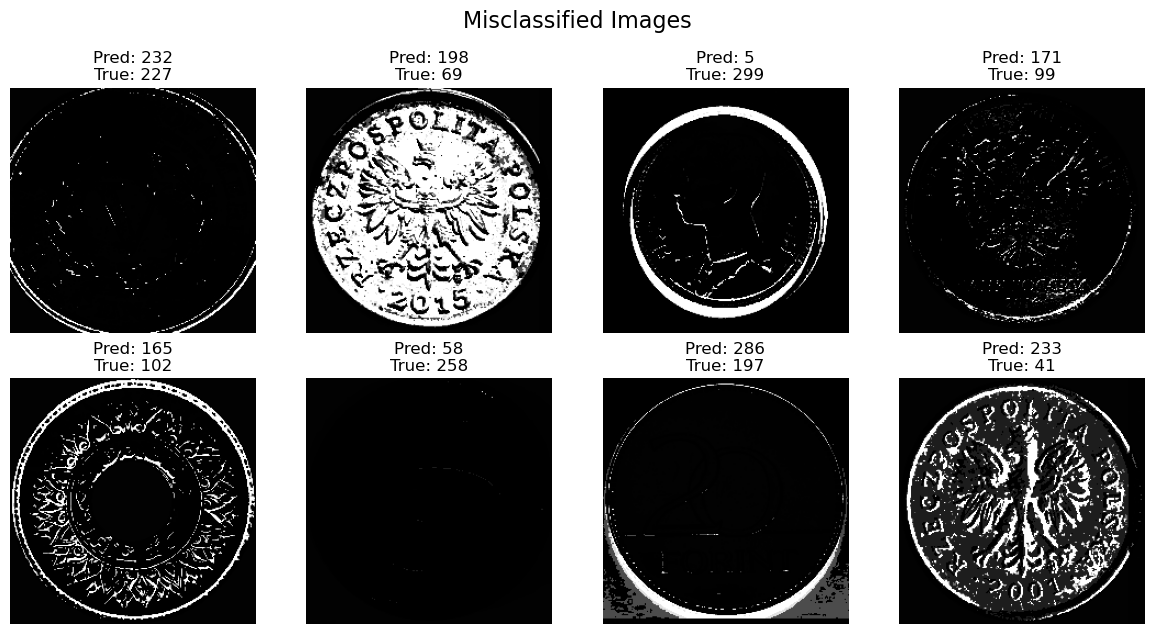

In [ ]:

# Load EfficientNet-B0 with pretrained weights
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Replace the classifier head
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 315)  # 315 classes
)

# Move model to device
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

# Train
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    n_epochs=15,
    device=device,
    model_name="efficientnet_b0_custom",
    use_early_stopping=True,
    use_scheduler=True
)


I think we will move on to training on the test data, I am experiencing a bottleneck at 83-84% accuracy, we will use the `resnet18_custom.pth` file to train

In [42]:
def create_class_to_idx(train_df):
    class_to_idx = dict(train_df[['Class', 'label']].drop_duplicates().values)
    return class_to_idx

def create_idx_to_class(train_df):
    idx_to_class = dict(train_df[['label', 'Class']].drop_duplicates().values)
    return idx_to_class

In [47]:
# Mapping functions
def create_class_to_idx(train_df):
    return dict(train_df[['Class', 'label']].drop_duplicates().values)

def create_idx_to_class(train_df):
    return dict(train_df[['label', 'Class']].drop_duplicates().values)

class_to_idx = create_class_to_idx(train_df)
idx_to_class = create_idx_to_class(train_df)



In [ ]:
# Test dataset class
class CoinDatasetTest(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['Id']
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, img_id
        except (FileNotFoundError, UnidentifiedImageError):
            return None, img_id

In [ ]:
# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
# Dataset & Dataloader for Test Data
test_dataset = CoinDatasetTest(test_df, test_img_dir, transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load model and modify the last layer (same as during training)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(512, len(class_to_idx))  # Ensure this matches the number of classes in training
)
model.load_state_dict(torch.load("../models/resnet18_custom.pth", map_location=device))
model = model.to(device)
model.eval()

# Predict on the test data and handle missing images
predictions = []
with torch.no_grad():
    for images, img_ids in tqdm(test_loader):
        batch_preds = []
        valid_images = []
        valid_ids = []

        # Filter out None images (i.e., missing files)
        for img, img_id in zip(images, img_ids):
            if img is not None:
                valid_images.append(img)
                valid_ids.append(img_id)
            else:
                # If image is missing, assign 'Unknown' class as a fallback
                predictions.append({
                    "Id": int(img_id),
                    "Class": 'Unknown',
                    "label": -1  # Represent missing class with -1
                })

        if valid_images:
            # Process valid images through the model
            valid_images = torch.stack(valid_images).to(device)
            outputs = model(valid_images)
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu().numpy()

            for img_id, pred in zip(valid_ids, preds):
                predictions.append({
                    "Id": int(img_id),
                    "Class": idx_to_class[pred],  # Map predicted label to class name
                    "label": int(pred)
                })

# Convert predictions to a DataFrame
submission_df = pd.DataFrame(predictions)

# Ensure the predictions are sorted by ID as required
submission_df = submission_df.sort_values("Id").reset_index(drop=True)

# Save the predictions to a CSV file
submission_df.to_csv("submission.csv", index=False)
print("Saved submission.csv")

100%|██████████| 21/21 [00:21<00:00,  1.04s/it]

Saved submission.csv 
